# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/Users/liyc/Desktop/project2/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: ./utils.py and /Users/liyc/Desktop/project2/utils.py are identical (not copied).
cp: ./samples and /Users/liyc/Desktop/project2/samples are identical (not copied).


In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    (h,w,channel) = sample.shape
    res = np.zeros((out_size,out_size,3),dtype=int)
    height = 0
    width = 0
    while height<out_size-patch_size:
        while width<out_size-patch_size:
            x = np.random.randint(0,h-patch_size)
            y = np.random.randint(0,w-patch_size)
            random_patch = sample[x:x+patch_size,y:y+patch_size,:]
            res[height:height+patch_size,width:width+patch_size,:] = random_patch
            width = width+patch_size
        height = height+patch_size
        width = 0
    return res
    



In [4]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample = cv2.imread(sample_img_fn)

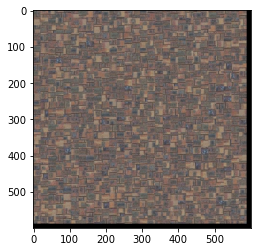

In [5]:
res = quilt_random(sample,600,21)
cv2.imwrite('quilt_random.jpg',res)
res = cv2.cvtColor(cv2.imread('quilt_random.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(res)
plt.show()

### Part II: Overlapping Patches (30 pts)

In [10]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # out_size = 300  # change these parameters as needed
    # patch_size = 25
    # overlap = 11
    # tol = 5
    res = np.zeros((out_size,out_size,3))
    num_blockHigh = ((out_size-patch_size)//(patch_size-overlap))+1
    num_blockWide = num_blockHigh
    for i in range(num_blockHigh):
        for j in range(num_blockWide):
            y = i * (patch_size - overlap)
            x = j * (patch_size - overlap)
            patch = choose_sample(sample, patch_size, overlap, res, y, x,tol)
            res[y:y+patch_size, x:x+patch_size] = patch
    res = res/255.0
    return res



def choose_sample(sample, patch_size, overlap, res, y, x,tol):
    h, w, channel = sample.shape
    errors = np.zeros((h - patch_size, w - patch_size))
    for i in range(h - patch_size):
        for j in range(w - patch_size):
            patch = sample[i:i+patch_size, j:j+patch_size]
            e = ssd_patch(patch, patch_size, overlap, res, y, x)
            errors[i, j] = e
    tmp = tol
    index_list = []
    while tmp >0:
        i, j = np.unravel_index(np.argmin(errors), errors.shape)
        index_list.append([i,j])
        errors[i,j] = 10000000
        tmp = tmp - 1
    chosen_index = index_list[np.random.randint(0,tol)]
    i = chosen_index[0]
    j = chosen_index[1]
    return sample[i:i+patch_size, j:j+patch_size]


def ssd_patch(patch, patch_size, overlap, res, y, x):
    error = 0
    if x > 0:
        left = patch[:, :overlap] - res[y:y+patch_size, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+patch_size]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

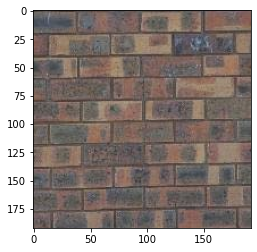

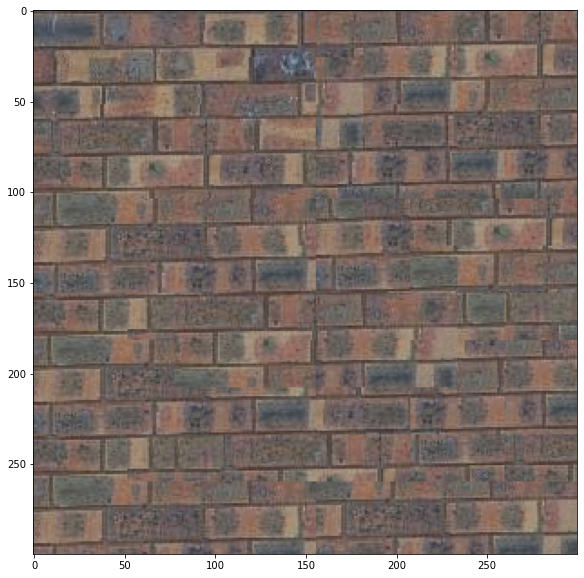

In [11]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 40
overlap = 14
tol = 3
res = quilt_simple(sample_img/255.0, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
res = res*255.0
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [12]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    res = np.zeros((out_size,out_size,3))
    num_blockHigh = ((out_size-patch_size)//(patch_size-overlap))+1
    num_blockWide = num_blockHigh
    for i in range(num_blockHigh):
        for j in range(num_blockWide):
            y = i * (patch_size - overlap)
            x = j * (patch_size - overlap)
            patch = choose_sample(sample, patch_size, overlap, res, y, x,tol)
            patch = minCutPatch(patch, patch_size, overlap, res, y, x)
            res[y:y+patch_size, x:x+patch_size] = patch
            print(x,y)
    return res
    
    
def minCutPatch(patch, block_size, overlap, res, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    minCut2 = np.zeros_like(patch)

    if x > 0:
        left = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        leftL2 = np.sum(left**2, axis=2) # 还是计算SSD
        minCut2[:, :overlap,0] = cut(leftL2.T).T
        minCut2[:, :overlap,1] = cut(leftL2.T).T
        minCut2[:, :overlap,2] = cut(leftL2.T).T
    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        upL2 = np.sum(up**2, axis=2)
        minCut2[:overlap, :,0] = cut(upL2)
        minCut2[:overlap, :,1] = cut(upL2)
        minCut2[:overlap, :,2] = cut(upL2)
    np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut2.astype(bool))

    return patch

def choose_sample(sample, patch_size, overlap, res, y, x,tol):
    h, w, channel = sample.shape
    errors = np.zeros((h - patch_size, w - patch_size))
    for i in range(h - patch_size):
        for j in range(w - patch_size):
            patch = sample[i:i+patch_size, j:j+patch_size]
            e = ssd_patch(patch, patch_size, overlap, res, y, x)
            errors[i, j] = e
    tmp = tol
    index_list = []
    while tmp >0:
        i, j = np.unravel_index(np.argmin(errors), errors.shape)
        index_list.append([i,j])
        errors[i,j] = 10000000000
        tmp = tmp - 1
    chosen_index = index_list[np.random.randint(0,tol)]
    i = chosen_index[0]
    j = chosen_index[1]
    # i, j = np.unravel_index(np.argmin(errors), errors.shape)
    # print(i,' ',j,'np.unravel_index(np.argmin(errors), errors.shape)')
    return sample[i:i+patch_size, j:j+patch_size]


def ssd_patch(patch, patch_size, overlap, res, y, x):
    error = 0
    if x > 0:
        left = patch[:, :overlap] - res[y:y+patch_size, x:x+overlap]
        error += np.sum(left**2)
        # print(left.shape)
        # print(error)

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+patch_size]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)
        # print(error)

    return error

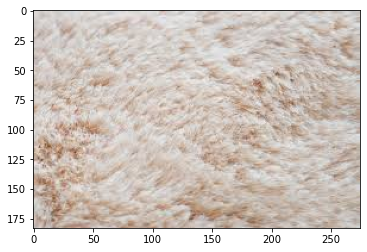

0 0
15 0
30 0
45 0
60 0
75 0
90 0
105 0
120 0
135 0
150 0
165 0
180 0
195 0
210 0
225 0
240 0
255 0
270 0
0 15
15 15
30 15
45 15
60 15
75 15
90 15
105 15
120 15
135 15
150 15
165 15
180 15
195 15
210 15
225 15
240 15
255 15
270 15
0 30
15 30
30 30
45 30
60 30
75 30
90 30
105 30
120 30
135 30
150 30
165 30
180 30
195 30
210 30
225 30
240 30
255 30
270 30
0 45
15 45
30 45
45 45
60 45
75 45
90 45
105 45
120 45
135 45
150 45
165 45
180 45
195 45
210 45
225 45
240 45
255 45
270 45
0 60
15 60
30 60
45 60
60 60
75 60
90 60
105 60
120 60
135 60
150 60
165 60
180 60
195 60
210 60
225 60
240 60
255 60
270 60
0 75
15 75
30 75
45 75
60 75
75 75
90 75
105 75
120 75
135 75
150 75
165 75
180 75
195 75
210 75
225 75
240 75
255 75
270 75
0 90
15 90
30 90
45 90
60 90
75 90
90 90
105 90
120 90
135 90
150 90
165 90
180 90
195 90
210 90
225 90
240 90
255 90
270 90
0 105
15 105
30 105
45 105
60 105
75 105
90 105
105 105
120 105
135 105
150 105
165 105
180 105
195 105
210 105
225 105
240 105
255 105
270 105


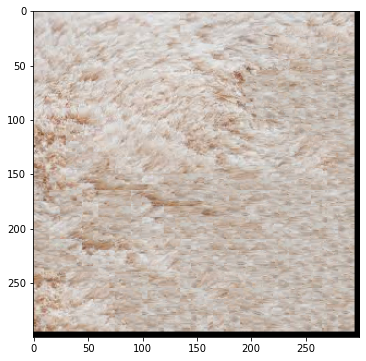

In [14]:
sample_img_fn = 'wool.jpeg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

save = np.zeros((25,25,3))
out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 10
tol = 6
res = quilt_cut(sample_img/255.0, out_size, patch_size, overlap, tol)
# res = res.astype(int)
cv2.imwrite('quilt_cut_res.jpg',res*255.0)
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [15]:
import heapq as heap

In [16]:
import heapq as heap
def choose_sample_transfer(sample, patch_size, overlap, tol,a,guidance_im,res, y, x):
    h  = sample.shape[0]
    w = sample.shape[1]
    errors = np.zeros((h - patch_size, w - patch_size))
    for i in range(h - patch_size):
        for j in range(w - patch_size):
            # patch = sample[i:i+patch_size, j:j+patch_size]
            patch = sample[i:i+patch_size, j:j+patch_size]
            texture_gray_patch = texture_img_gauss[i:i+patch_size, j:j+patch_size]
            # use texture_img_gauss to calculate SSD
            e = ssd_patch(texture_gray_patch,patch, patch_size, overlap, res, y, x,a,guidance_im)
            errors[i, j] = e
#             print('1111')
#     print(errors.min())
    tmp = tol
    index_list = []
    while tmp >0:
        i, j = np.unravel_index(np.argmin(errors), errors.shape)
        index_list.append([i,j])
        errors[i,j] = 1000000000000
        tmp = tmp - 1
    chosen_index = index_list[np.random.randint(0,tol)]
    i = chosen_index[0]
    j = chosen_index[1]
    # and return a part of the sample
    return sample[i:i+patch_size, j:j+patch_size],texture_img_gauss[i:i+patch_size, j:j+patch_size]


def ssd_patch(texture_gray_patch,patch, patch_size, overlap, res, y, x,a,guidance_im):
    error = 0
    if x > 0:
        x_error = patch[:, :overlap] - res[y:y+patch_size, x:x+overlap]
        # use sample(3 channel) to calculate SSD
        error += a*np.sum(x_error**2)
        # use gray_patch(1 channel) to calculate SSD
        # calculate SSD based on the whold patch instead of the overlapping region
        # x_error_trans = texture_gray_patch[:, :overlap] - guidance_im[y:y+patch_size, x:x+overlap]
        x_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
        error += (1-a)*np.sum(x_error_trans**2)

    if y > 0:
        y_error = patch[:overlap, :] - res[y:y+overlap, x:x+patch_size]
        error += np.sum(y_error**2)
        # y_error_trans = texture_gray_patch[:overlap, :] - guidance_im[y:y+overlap, x:x+patch_size]
        y_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
        error += (1-a)*np.sum(y_error_trans**2)

    if x > 0 and y > 0:
        xy_error = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(xy_error**2)
        # xy_error_trans = texture_gray_patch[:overlap, :overlap] - guidance_im[y:y+overlap, x:x+overlap]
        xy_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
        error -= (1-a)*np.sum(xy_error_trans**2)
    return error

def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    out_size = guidance_im.shape[0]
    res = np.zeros((out_size,out_size,3))
    num_blockHigh = ((out_size-patch_size)//(patch_size-overlap))+1
    num_blockWide = num_blockHigh
    for i in range(num_blockHigh):
        for j in range(num_blockWide):
            y = i * patch_size - i*overlap
            x = j * patch_size - j*overlap
            print(x,y)
            patch,gauss_patch = choose_sample_transfer(sample, patch_size, overlap,tol,alpha,guidance_im,res, y, x)
            patch = minCutPatch_transfer(gauss_patch,patch, patch_size, overlap,alpha,res, y, x)
            res[y:y+patch_size, x:x+patch_size] = patch
    return res
    
    
def minCutPatch_transfer(gauss_patch,patch, block_size, overlap,a, res, y, x):
    patch = patch.copy()
    dy = patch.shape[0]
    dx = patch.shape[1]
    minCut2 = np.zeros_like(patch)
    minCut1 = np.zeros_like(patch, dtype=bool) # 疑似mask
    if x > 0:
        x_ssd = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        x_transfer_ssd = a*np.sum(x_ssd**2)
        t_ssd = gauss_patch[:, :overlap] - guidance_img_gauss[y:y+dy, x:x+overlap]
        # use filtered image to calculate
        x_transfer_ssd += (1-a)*(t_ssd**2)
        # minCut2[:, :overlap,0] = cut(x_transfer_ssd.T).T
        # minCut2[:, :overlap,1] = cut(x_transfer_ssd.T).T
        # minCut2[:, :overlap,2] = cut(x_transfer_ssd.T).T
        for i, j in enumerate(minCutPath(x_transfer_ssd)):
            minCut1[i, :j] = True
    if y > 0:
        y_ssd = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        y_transfer_ssd = a*np.sum(y_ssd**2)
        t_ssd = gauss_patch[:overlap, :] - guidance_img_gauss[y:y+overlap, x:x+dx]
        y_transfer_ssd += (1-a)*(t_ssd**2)
        # minCut2[:overlap, :,0] = cut(y_transfer_ssd)
        # minCut2[:overlap, :,1] = cut(y_transfer_ssd)
        # minCut2[:overlap, :,2] = cut(y_transfer_ssd)
        for j, i in enumerate(minCutPath(y_transfer_ssd.T)):
            minCut1[:i, j] = True
        np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut1.astype(bool))
#     np.copyto(patch, res[y:y+dy, x:x+dx].astype(np.uint8), where=minCut1.astype(bool))
    # numpy.copyto(dst, src, casting='same_kind', where=True)
    return patch


def minCutPath(errors):
    visited = set()
    # use a set to record the visited data
    error_row = [(error, [i]) for i, error in enumerate(errors[0])]
    heap.heapify(error_row)
    # use heap to avoid go over the whole list again and again
    height_size = errors.shape[0]
    width_size = errors.shape[1]
    while error_row:
        error, error_path = heap.heappop(error_row)
        current_depth = len(error_path)
        current_index = error_path[-1]
        if current_depth != height_size:
            for step in range(-1,2):
                nextIndex = current_index + step
                # move forward to try
                if (current_depth, nextIndex) not in visited:
                    if nextIndex < width_size  and nextIndex>=0:
                        cumulatedError = errors[current_depth, nextIndex] + error
                        heap.heappush(error_row, (cumulatedError, [nextIndex] + error_path))
                        visited.add((current_depth, nextIndex))
                        # record this visit
        else:
            # the path has been found
            return error_path

0 0
13 0
26 0
39 0
52 0
65 0
78 0
91 0
104 0
117 0
130 0
143 0
156 0
169 0
182 0
195 0
208 0
221 0
234 0
247 0
260 0
273 0
0 13
13 13
26 13
39 13
52 13
65 13
78 13
91 13
104 13
117 13
130 13
143 13
156 13
169 13
182 13
195 13
208 13
221 13
234 13
247 13
260 13
273 13
0 26
13 26
26 26
39 26
52 26
65 26
78 26
91 26
104 26
117 26
130 26
143 26
156 26
169 26
182 26
195 26
208 26
221 26
234 26
247 26
260 26
273 26
0 39
13 39
26 39
39 39
52 39
65 39
78 39
91 39
104 39
117 39
130 39
143 39
156 39
169 39
182 39
195 39
208 39
221 39
234 39
247 39
260 39
273 39
0 52
13 52
26 52
39 52
52 52
65 52
78 52
91 52
104 52
117 52
130 52
143 52
156 52
169 52
182 52
195 52
208 52
221 52
234 52
247 52
260 52
273 52
0 65
13 65
26 65
39 65
52 65
65 65
78 65
91 65
104 65
117 65
130 65
143 65
156 65
169 65
182 65
195 65
208 65
221 65
234 65
247 65
260 65
273 65
0 78
13 78
26 78
39 78
52 78
65 78
78 78
91 78
104 78
117 78
130 78
143 78
156 78
169 78
182 78
195 78
208 78
221 78
234 78
247 78
260 78
273 78
0 91
13

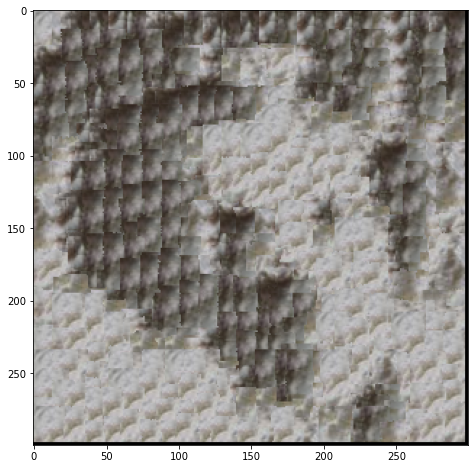

In [20]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 12

tol = 5
alpha = 0.4
# texture_path = 'toast.jpg'
texture_path = 'white_small.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_path), cv2.COLOR_BGR2RGB)
guidance_path = 'feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_path), cv2.COLOR_BGR2RGB)
guidance_img = cv2.resize(guidance_img,(300,300))
t_gray = cv2.cvtColor(texture_img,cv2.COLOR_RGB2GRAY)
g_gray = cv2.cvtColor(guidance_img,cv2.COLOR_RGB2GRAY)
texture_img_gauss = cv2.GaussianBlur(t_gray, ksize=(0,0), sigmaX=5)/255.0
guidance_img_gauss = cv2.GaussianBlur(g_gray, ksize=(0,0), sigmaX=5)/255.0
cv2.imwrite('t_gauss.jpg',texture_img_gauss)
cv2.imwrite('g_gauss.jpg',guidance_img_gauss)
# pass the filtered image of guidance_im
res = texture_transfer(texture_img/255.0, patch_size, overlap, tol, guidance_img_gauss, alpha)
# res = res.astype(int)
cv2.imwrite('res.jpg',res*255.0)
plt.figure(figsize=(8,8))
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [ ]:
# customized cut
def minCutPath(errors):
    visited = set()
    # use a set to record the visited data
    error_row = [(error, [i]) for i, error in enumerate(errors[0])]
    heap.heapify(error_row)
    # use heap to avoid go over the whole list again and again
    height_size = errors.shape[0]
    width_size = errors.shape[1]
    while error_row:
        error, error_path = heap.heappop(error_row)
        current_depth = len(error_path)
        current_index = error_path[-1]
        if current_depth != height_size:
            for step in range(-1,2):
                nextIndex = current_index + step
                # move forward to try
                if (current_depth, nextIndex) not in visited:
                    if nextIndex < width_size  and nextIndex>=0:
                        cumulatedError = errors[current_depth, nextIndex] + error
                        heap.heappush(error_row, (cumulatedError, [nextIndex] + error_path))
                        visited.add((current_depth, nextIndex))
                        # record this visit
        else:
            # the path has been found
            return error_path

In [18]:
# ------------------ 以下是迭代版本的代码
def choose_sample_transfer_iteration(sample, patch_size, overlap, tol,a,guidance_im,res, y, x):
    h  = sample.shape[0]
    w = sample.shape[1]
    errors = np.zeros((h - patch_size, w - patch_size))
    for i in range(h - patch_size):
        for j in range(w - patch_size):
            # patch = sample[i:i+patch_size, j:j+patch_size]
            patch = sample[i:i+patch_size, j:j+patch_size]
            texture_gray_patch = texture_img_gauss[i:i+patch_size, j:j+patch_size]
            # use texture_img_gauss to calculate SSD
            e = ssd_patch_iteration(texture_gray_patch,patch, patch_size, overlap, res, y, x,a,guidance_im)
            errors[i, j] = e
    tmp = tol
    index_list = []
    while tmp >0:
        i, j = np.unravel_index(np.argmin(errors), errors.shape)
        index_list.append([i,j])
        errors[i,j] = 1000000000000
        tmp = tmp - 1
    chosen_index = index_list[np.random.randint(0,tol)]
    i = chosen_index[0]
    j = chosen_index[1]
    # and return a part of the sample
    return sample[i:i+patch_size, j:j+patch_size],texture_img_gauss[i:i+patch_size, j:j+patch_size]


def ssd_patch_iteration(texture_gray_patch,patch, patch_size, overlap, res, y, x,a,guidance_im):
    error = 0
    if x > 0:
        x_error = patch[:, :overlap] - res[y:y+patch_size, x:x+overlap]
        # use sample(3 channel) to calculate SSD
        error += a*np.sum(x_error**2)
        # use gray_patch(1 channel) to calculate SSD
        # calculate SSD based on the whold patch instead of the overlapping region
        # x_error_trans = texture_gray_patch[:, :overlap] - guidance_im[y:y+patch_size, x:x+overlap]
        x_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
        error += (1-a)*np.sum(x_error_trans**2)

    if y > 0:
        y_error = patch[:overlap, :] - res[y:y+overlap, x:x+patch_size]
        error += np.sum(y_error**2)
        # y_error_trans = texture_gray_patch[:overlap, :] - guidance_im[y:y+overlap, x:x+patch_size]
        y_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
        error += (1-a)*np.sum(y_error_trans**2)

    if x > 0 and y > 0:
        xy_error = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(xy_error**2)
        # xy_error_trans = texture_gray_patch[:overlap, :overlap] - guidance_im[y:y+overlap, x:x+overlap]
    xy_error_trans = texture_gray_patch - guidance_im[y:y+patch_size, x:x+patch_size]
    error += (1-a)*np.sum(xy_error_trans**2)
    # new parameter: former_pic, 3channels
    f_error = patch - former_pic[y:y+patch_size, x:x+patch_size]
    error += (1-a)*np.sum(f_error**2)
    return error

def texture_transfer_iteration(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    out_size = guidance_im.shape[0]
    res = np.zeros((out_size,out_size,3))
    num_blockHigh = ((out_size-patch_size)//(patch_size-overlap))+1
    num_blockWide = num_blockHigh
    for i in range(num_blockHigh):
        for j in range(num_blockWide):
            y = i * patch_size - i*overlap
            x = j * patch_size - j*overlap
            print(x,y)
            patch,gauss_patch = choose_sample_transfer_iteration(sample, patch_size, overlap,tol,alpha,guidance_im,res, y, x)
            patch = minCutPatch_transfer_iteration(gauss_patch,patch, patch_size, overlap,alpha,res, y, x)
            res[y:y+patch_size, x:x+patch_size] = patch
    return res
    
    
def minCutPatch_transfer_iteration(gauss_patch,patch, block_size, overlap,a, res, y, x):
    patch = patch.copy()
    dy = patch.shape[0]
    dx = patch.shape[1]
    minCut2 = np.zeros_like(patch)
    minCut1 = np.zeros_like(patch, dtype=bool) # 疑似mask
    if x > 0:
        x_ssd = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        x_transfer_ssd = a*np.sum(x_ssd**2)
        t_ssd = gauss_patch[:, :overlap] - guidance_img_gauss[y:y+dy, x:x+overlap]
        # use filtered image to calculate
        x_transfer_ssd += (1-a)*(t_ssd**2)
        # iterative method
        i_ssd = patch[:, :overlap]-former_pic[y:y+dy, x:x+overlap]
        x_transfer_ssd += (1-a)*np.sum(i_ssd**2,axis=2)
        # minCut2[:, :overlap,0] = cut(x_transfer_ssd.T).T
        # minCut2[:, :overlap,1] = cut(x_transfer_ssd.T).T
        # minCut2[:, :overlap,2] = cut(x_transfer_ssd.T).T
        for i, j in enumerate(minCutPath(x_transfer_ssd)):
            minCut1[i, :j] = True
    if y > 0:
        y_ssd = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        y_transfer_ssd = a*np.sum(y_ssd**2)
        t_ssd = gauss_patch[:overlap, :] - guidance_img_gauss[y:y+overlap, x:x+dx]
        y_transfer_ssd += (1-a)*(t_ssd**2)
        i_ssd = patch[:overlap, :] - former_pic[y:y+overlap, x:x+dx]
        y_transfer_ssd += (1-a)*np.sum(i_ssd**2,axis=2)
        # minCut2[:overlap, :,0] = cut(y_transfer_ssd)
        # minCut2[:overlap, :,1] = cut(y_transfer_ssd)
        # minCut2[:overlap, :,2] = cut(y_transfer_ssd)
        for j, i in enumerate(minCutPath(y_transfer_ssd.T)):
            minCut1[:i, j] = True
        np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut1.astype(bool))
#     np.copyto(patch, res[y:y+dy, x:x+dx].astype(np.uint8), where=minCut1.astype(bool))
    # numpy.copyto(dst, src, casting='same_kind', where=True)
    return patch



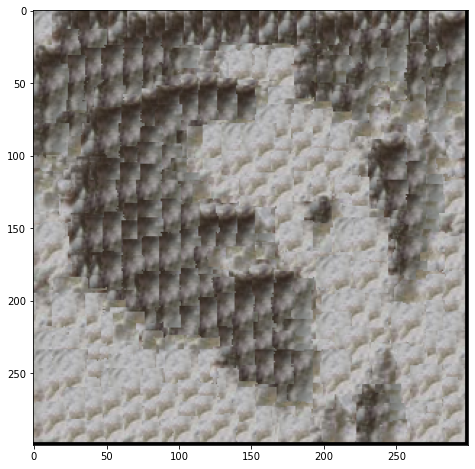

In [19]:
texture_path = 'white_small.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_path), cv2.COLOR_BGR2RGB)
guidance_path = 'feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_path), cv2.COLOR_BGR2RGB)
guidance_img = cv2.resize(guidance_img,(300,300))
t_gray = cv2.cvtColor(texture_img,cv2.COLOR_RGB2GRAY)
g_gray = cv2.cvtColor(guidance_img,cv2.COLOR_RGB2GRAY)
texture_img_gauss = cv2.GaussianBlur(t_gray, ksize=(0,0), sigmaX=5)/255.0
guidance_img_gauss = cv2.GaussianBlur(g_gray, ksize=(0,0), sigmaX=5)/255.0

# use three iterations 
ps_list = [48,32,24]
overlap = 12
alpha = 0.1 # use the given parameters to calculate alpha
# calculate the result to prepare for iterative method
former_pic = texture_transfer(texture_img/255.0, ps_list[0], overlap, tol, guidance_img_gauss, alpha)
alpha = 0.5
former_pic = texture_transfer_iteration(texture_img/255.0, ps_list[1], overlap, tol, guidance_img_gauss, alpha)
alpha = 0.9
res = texture_transfer_iteration(texture_img/255.0, ps_list[2], overlap, tol, guidance_img_gauss, alpha)


# pass the filtered image of guidance_im
res = texture_transfer(texture_img/255.0, patch_size, overlap, tol, guidance_img_gauss, alpha)
cv2.imwrite('res.jpg',res*255.0)
plt.figure(figsize=(8,8))
plt.imshow(res)
plt.show()

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).